# ASTR 400B Research Assignment:
This code is a draft for what will be used for my final project.
The general topic of my research assignment is analyzing how galaxies and dark matter halos evolve together through mergers. The major question is whether the dark matter halo remnant will be prograde or retrograde, relative to the rotation of the baryon disk. This code will focus on the angular momentum calculation which is then used to analyze whether the halo is prograde or retrograde.

academic papers used for inspiration and thought:
-------------------------------------------------
Drakos+2019 (discussion of dark matter halo mergers)\
Chua+2019 (claim that with baryon matter, halos are more spherical)\
Teklu+2015 (discussion of angular momentum in disk and halo)\
Carollo+2007 (claim retrograde and prograde MW halo)\
Koppelman+2019 (claim retrograde MW halo)

In [1]:
# import modules
import numpy as np
import astropy.units as u

# import plotting module
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# import previous code
from ReadFile import Read
from CenterOfMassSoln import CenterOfMass  # try COM instead of COM2
from ParticleProperties2 import ParticleProperties

# for contours
import scipy.optimize as so

# Rotate M31 Data (not necessary...?)
The disk of M31 is tilted from the simulation data and we want the data to represent M31 on the same axes as the MW. The following code is from Lab 7.

In [3]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    
    # normalize the angular momentum vector
    L_norm = L/np.sqrt(np.sum(L**2))

    # Set up rotation matrix to map L_norm to
    # z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

# Angular Momentum
To calculate the angular momentum:
\begin{equation}
    \vec{L} = \sum_{i} \vec{r_i} \times \vec{p_i} = \sum_{i} m_i (\vec{r_i} \times \vec{v_i})
\end{equation}
To answer this question, we need to analyze the direction of the angular momentum of the halo and the angular momentum of the disk. If the dark matter halo is prograde, the orbital rotation is in the same direction and if the dark matter halo is retrograde, the orbital rotation is in the opposite direction. For the variables: $m_i$ is the mass of the individual particle, $r_i$ is the three-dimensional position vector of the particle, adjusted for the center of mass position, and $v_i$ is the three-dimensional velocity vector of the particle, also adjusted for the center of mass velocity. The sum is the addition of the angular momentum for all particles of that type (either dark matter or disk). We will retrieve the particle data from different functions. The radius of the particle will come from the ParticleProperties function and the COM_P function within the CenterOfMass class. The velocity of the particle will also come from the ParticleProperties function and the COM_V function within the CenterOfMass class. The mass of the particle will come from the ParticleProperties function.

In [5]:
def AngularMomentumMW(filename, type, r_max=None):
    '''
        This function calculates the angular momentum of a galaxy component of the MW

        PARAMETERS:
        -----------
            filename: 'str'
                the name of the file containing galaxy information
            type: 'int' (i.e. 1, 2, or 3)
                the particle type (1 for halo, 2 for disk)
            r_max: 'float'
                the max radius of considered particles

        OUTPUT:
        -------
            AngularMomentumMW: np.array
                the angular momentum of the galaxy component of the MW in kg m^2/s
    '''
    
    # set tolerance for calculating COM_P in CenterOfMass
    delta = 0.1
    
    # intialize a 3D array for angular momentum
    # stores the total angular momentum of the galaxy component at each snapshot
    AngularMomentumMW = np.zeros(3)

    # assign variables to the outputs of the Read function
    time, N, data = Read(filename)

    # store variables imported from ParticleProperties
    r, v, m, Npart = ParticleProperties(filename, type, int(N))

    # at any given time, we know com p and com v for the galaxy component (either disk or halo)
    # create an instance of CenterofMass class for galaxy with particle type
    galaxy_COM = CenterOfMass(filename, type)

    # storing the COM position and COM velocity
    r_COM = galaxy_COM.COM_P(delta)
    v_COM = galaxy_COM.COM_V(r_COM[0], r_COM[1], r_COM[2])

    #print(f'r from part prop: {r}')
    #print(f'v from part prop: {v}')
    #print(f'r com: {r_COM}')
    #print(f'v com: {v_COM}')
    
    # update the radii and velocities to be in the COM frame
    # check shapes --> r_COM will only be one vector
    r_new = r - r_COM.value
    v_new = v - v_COM.value

    #print(f'r new: {r_new}')
    #print(f'v new: {v_new}')

    # initialize the variables to be calculated within the for loop
    r_new_mag = np.zeros(Npart)

    # FIND AVERAGE NOT SUM
    
    # loop through the particles of a certain type
    for i in range(Npart):
        
        # calculate the distance
        #r_new_mag = np.linalg.norm(r_new)
        sum_of_squares = r_new[i, 0]**2 + r_new[i, 1]**2 + r_new[i, 2]**2
        r_new_mag[i] = np.sqrt(sum_of_squares)

        # ensure the magnitude of the radius of the particle is within the max radius
        # for that galaxy component (previously defined for the MW)
        if r_new_mag[i] <= r_max:
            
            # calculate angular momentum for the ith particle
            AngularMomentum_ith = m[i] * np.cross(r_new[i], v_new[i])
        
            # total angular momentum for the galaxy component would be the sum of every 
            # particle's angular momentum in that galaxy component

            # angular momentum of all the particles in the galaxy component at
            # a given snapshot
            AngularMomentumMW = np.mean(AngularMomentum_ith)
        
        '''
        index2 = np.where(r_new_mag[i] <= r_max)

        mass = m[i]
        radius = r_new[i]
        velocity = v_new[i]

        print(f'mass: {mass}')
        print(f'radius: {radius}')
        print(f'velocity: {velocity}')

        
        m_calc = mass[index2]
        r_calc = radius[index2]
        v_calc = velocity[index2]
        
        print(f'r_calc: {r_calc}')
        print(f'r_calc: {r_calc}')
        
        
        AngularMomentum_ith = m_calc * np.cross(r_calc, v_calc)

        AngularMomentumMW = np.mean(AngularMomentum_ith)

        '''
        
    return AngularMomentumMW

In [6]:
def AngularMomentumM31(filename, type, r_max=None):
    '''
        This function calculates the angular momentum of a galaxy component of M31

        PARAMETERS:
        -----------
            filename: 'str'
                the name of the file containing galaxy information
            type: 'int' (i.e. 1, 2, or 3)
                the particle type (1 for halo, 2 for disk)
            r_max: 'float'
                the max radius of considered particles

        OUTPUT:
        -------
            AngularMomentumM31: np.array
                the angular momentum of the galaxy component of M31 in kg m^2/s
    '''

    # set tolerance for calculating COM_P in CenterOfMass
    delta = 0.1
    
    # intialize a 3D array for angular momentum
    # stores the total angular momentum of the galaxy component at each snapshot
    AngularMomentumM31 = np.zeros(3)

    # assign variables to the outputs of the Read function
    time, N, data = Read(filename)

    # store variables imported from ParticleProperties
    r, v, m, Npart = ParticleProperties(filename, type, int(N))

    #print(f'pp r: {r}')
    #print(f'pp v: {v}')

    # USE ROTATE FRAME OUT OF THE FUNCTION????????

    #print(f'rotated r: {rn}')
    #print(f'rotated v: {vn}')

    # at any given time, we know com p and com v for the galaxy component (either disk or halo)
    # create an instance of CenterofMass class for galaxy with particle type
    galaxy_COM = CenterOfMass(filename, type)

    # store the COM position and COM velocity
    r_COM = galaxy_COM.COM_P(delta)
    v_COM = galaxy_COM.COM_V(r_COM[0], r_COM[1], r_COM[2])

    # update the radii and velocities to be in the COM frame
    r_new = r - r_COM.value
    v_new = v - v_COM.value

    # compute the rotated position and velocity vectors using RotateFrame function
    rn, vn = RotateFrame(r_new,v_new)

    #print(f'r new: {r_new}')
    #print(f'v new: {v_new}')

    # initialize the variables to be calculated within the for loop
    r_new_mag = np.zeros(Npart)

    # loop through the particles of a certain type
    for i in range(Npart):
        
        # calculate the distance
        #r_new_mag = np.linalg.norm(r_new)
        sum_of_squares = rn[i, 0]**2 + rn[i, 1]**2 + rn[i, 2]**2
        r_new_mag[i] = np.sqrt(sum_of_squares)
        
        # need the magnitude projected within the plane of the disk?
        # choose along which axis?

        #print(f'r new mag: {r_new_mag}')
        #print(f'r max: {r_max}')

        # ensure the magnitude of the radius of the particle is within the max radius
        # for that galaxy component (previously defined for M31)
        if r_new_mag[i] <= r_max:

            # calculate angular momentum for the ith particle
            AngularMomentum_ith = m[i] * np.cross(rn[i], vn[i])
        
            # total angular momentum for the galaxy component would be the sum of every 
            # particle's angular momentum in that galaxy component

            # angular momentum of all the particles in the galaxy component at
            # a given snapshot
            AngularMomentumM31 += AngularMomentum_ith

    return AngularMomentumM31


# Determining the Angular Momenta

Analyzing the individual galaxies throughout time:
--------------------------------------------------

In [9]:
# initialize arrays for plotting

n = 17
times = np.zeros(n)

MW_halo_L = np.zeros((n,3))
MW_disk_L = np.zeros((n,3))
MW_halo_L_mag = np.zeros(n)
MW_disk_L_mag = np.zeros(n)

M31_halo_L = np.zeros((n,3))
M31_disk_L = np.zeros((n,3))
M31_halo_L_mag = np.zeros(n)
M31_disk_L_mag = np.zeros(n)

In [10]:
# loop through the snapshots for each galaxy
for i, snapshot in enumerate(np.arange(0,801,50)):

    # extract the text files from each galaxy folder
    MW_file = r'C:\\Users\\savan\\MW' + f'/MW_{snapshot:03d}' + '.txt'
    M31_file = r'C:\\Users\\savan\\M31' + f'/M31_{snapshot:03d}' + '.txt'

    # read time for plotting
    time, _, _ = Read(MW_file)
    times[i] = time.to(u.Gyr).value

    # compute the angular momenta for MW
    MW_halo_L[i,:] = AngularMomentumMW(MW_file, 1, 62)
    MW_disk_L[i,:] = AngularMomentumMW(MW_file, 2, 15)

    # compute the magntide of vectors
    MW_halo_L_mag[i] = np.linalg.norm(MW_halo_L)
    MW_disk_L_mag[i] = np.linalg.norm(MW_disk_L)

    # compute the angular momenta for M31
    M31_halo_L[i,:] = AngularMomentumMW(M31_file, 1, 62)
    M31_disk_L[i,:] = AngularMomentumMW(M31_file, 2, 20)

    # compute the magnitude of vectors
    M31_halo_L_mag[i] = np.linalg.norm(M31_halo_L)
    M31_disk_L_mag[i] = np.linalg.norm(M31_disk_L)


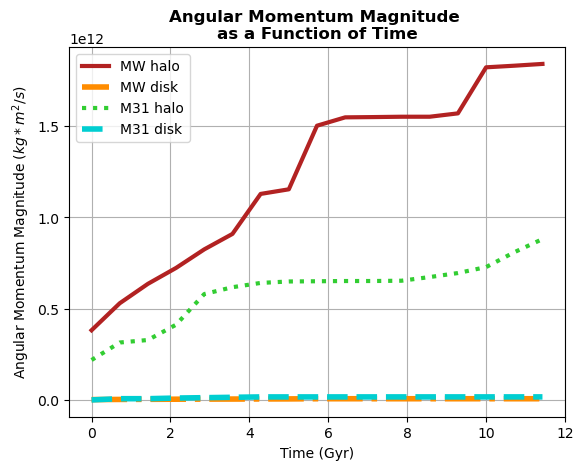

In [11]:
# plot angular momentum magnitude versus time
plt.title('Angular Momentum Magnitude \nas a Function of Time').set_weight('bold')
plt.xlabel('Time (Gyr)')
plt.ylabel(f'Angular Momentum Magnitude ($kg*m^2/s$)')  # DOUBLE CHECK UNITSSSSSSSSSSSS SPEED IS IN KM/S AND MASS IN 1E10 
# USE SPECIFIC ANGULAR MOMENTUM
plt.grid(True)

plt.plot(times, MW_halo_L_mag, lw=3, color='firebrick', label='MW halo')
plt.plot(times, MW_disk_L_mag, linestyle='-.', lw=4, color='darkorange', label='MW disk')
plt.plot(times, M31_halo_L_mag, linestyle=':', lw=3, color='limegreen', label='M31 halo')
plt.plot(times, M31_disk_L_mag, linestyle='--', lw=4, color='darkturquoise', label='M31 disk')

# adjust tick label font size
label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend()
plt.savefig('AngularMomentumMagVsTimePREMERGER.png')

Analyzing the galaxy remnant after 6.5 Gyr in the future:
---------------------------------------------------------

In [13]:
# from homework 6, question 3: MW-M31 merge between 6.5 and 7 Gyr (somewhere around 6.7 Gyr)
# correlates to a snapshot of 469
# with the snapshots I loop through, the first snapshot to analyze the remnant would be 450

n_merger = 9

times_post = np.zeros(n_merger)

remnant_halo_L = np.zeros((n_merger,3))
remnant_disk_L = np.zeros((n_merger,3))

remnant_halo_L_mag = np.zeros(n_merger)
remnant_disk_L_mag = np.zeros(n_merger)

In [14]:
# loop through the snapshots for each galaxy
for i, snapshot in enumerate(np.arange(450,801,50)):

    # extract the text files from each galaxy folder
    MW_file = r'C:\\Users\\savan\\MW' + f'/MW_{snapshot:03d}' + '.txt'
    M31_file = r'C:\\Users\\savan\\M31' + f'/M31_{snapshot:03d}' + '.txt'

    # read time for plotting
    time, _, _ = Read(MW_file)
    times_post[i] = time.to(u.Gyr).value

    # compute the angular momenta for MW
    remnant_halo_L[i,:] = AngularMomentumMW(MW_file, 1, 62) + AngularMomentumMW(M31_file, 1, 62)
    remnant_disk_L[i,:] = AngularMomentumMW(MW_file, 2, 15) + AngularMomentumMW(M31_file, 2, 20)

    # UNCERTAINTY: USED INDIVIDUAL COM BUT NOT CORRECT FOR REMNANT

    # compute the magntide of vectors
    remnant_halo_L_mag[i] = np.linalg.norm(remnant_halo_L)
    remnant_disk_L_mag[i] = np.linalg.norm(remnant_disk_L)


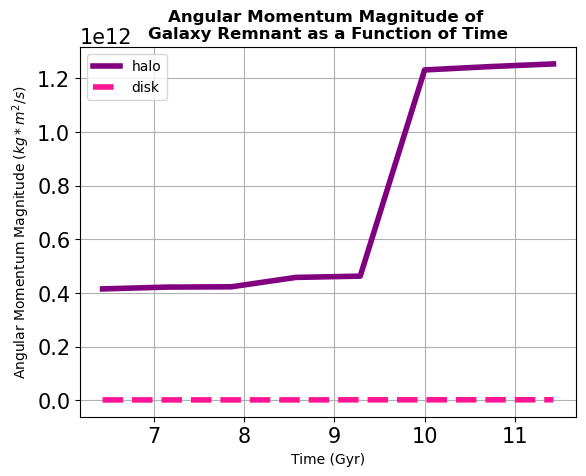

In [15]:
# plot angular momentum magnitude versus time POST-MERGER

plt.title('Angular Momentum Magnitude of \nGalaxy Remnant as a Function of Time').set_weight('bold')
plt.xlabel('Time (Gyr)')
plt.ylabel(f'Angular Momentum Magnitude ($kg*m^2/s$)')
plt.grid(True)

plt.plot(times_post[:-1], remnant_halo_L_mag[:-1], lw=4, color='purple', label='halo')
plt.plot(times_post[:-1], remnant_disk_L_mag[:-1], linestyle='--', lw=4, color='deeppink', label='disk')

# adjust tick label font size
label_size = 10
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend()
plt.savefig('AngularMomentumMagVsTimePOSTMERGER.png')

# Prograde or Retrograde?
Because the angular momentum vectors are in 3D and the directions are not simply clockwise or counterclockwise, we must calculate the dot product between the two vectors to determine whether they oppose each other or not.
\begin{equation}
    \vec{L_{halo}} \cdot \vec{L_{disk}} = |\vec{L_{halo}}||\vec{L_{disk}}|cos\theta \rightarrow cos\theta = \frac{\vec{L_{halo}} \cdot \vec{L_{disk}}}{|\vec{L_{halo}}||\vec{L_{disk}}|}
\end{equation}
If the cosine term is negative, the orbit of the dark matter halo is retrograde. If the cosine term is positive, the orbit of the dark matter halo is prograde.

Analyzing the individual galaxies throughout time:
--------------------------------------------------

In [18]:
MW_cos = np.zeros(n)
M31_cos = np.zeros(n)

for i in range(n):

    # compute the dot product of MW components before merger
    MW_dot = np.dot(MW_halo_L[i], MW_disk_L[i])
    # compute the cosine term for MW
    MW_cos[i] = MW_dot / (MW_halo_L_mag[i] * MW_disk_L_mag[i])
    
    # compute the dot product of M31 components before merger
    M31_dot = np.dot(M31_halo_L[i], M31_disk_L[i])
    # compute the cosine term for M31
    M31_cos[i] = M31_dot / (M31_halo_L_mag[i] * M31_disk_L_mag[i])


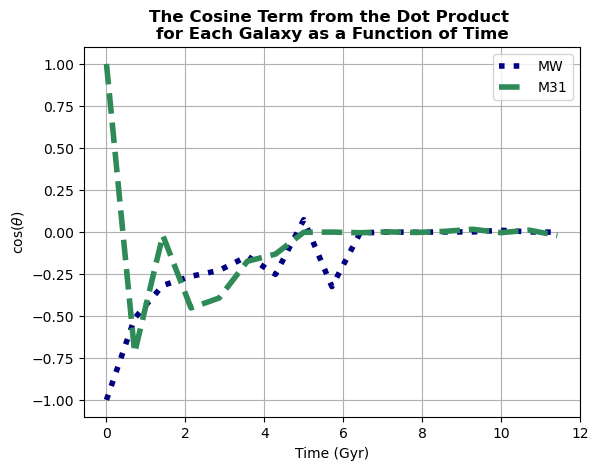

In [19]:
# plot the dot product as a function of time

plt.title('The Cosine Term from the Dot Product \nfor Each Galaxy as a Function of Time').set_weight('bold')

plt.plot(times, MW_cos, lw=4, linestyle=':', color='navy', label='MW')
plt.plot(times, M31_cos, lw=4, linestyle='--', color='seagreen', label='M31')

plt.legend()
plt.grid(True)

# add axis labels
plt.xlabel('Time (Gyr)')
plt.ylabel(r'cos($\theta$)')  # put "equation" in for the axis label??????????

# adjust tick label font size
label_size = 10
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('CosineTermVsTimePREMERGER.png')

# compare what is seen in the plot to what is actually going on !!!!!!!!!!!!!!!!!! encounters !!!!!!!!!!!!!!!!!!!!
# subfigure with orbit???????????????? vertical lines?????????????????????


# THETA AT TIME 0 SHOULD BE ONE
# PRINT ANGULAR MOMENTUM 


# SOMETHING WRONG WITH ROTATION

Analyzing the galaxy remnant after 6.5 Gyr in the future:
---------------------------------------------------------

In [21]:
remnant_cos = np.zeros(n_merger-1)

for i in range(n_merger-1):

    # compute the dot product of remnant components after merger
    remnant_dot = np.dot(remnant_halo_L[i], remnant_disk_L[i])
    # compute the cosine term for the remnant
    remnant_cos[i] = remnant_dot / (remnant_halo_L_mag[i] * remnant_disk_L_mag[i])


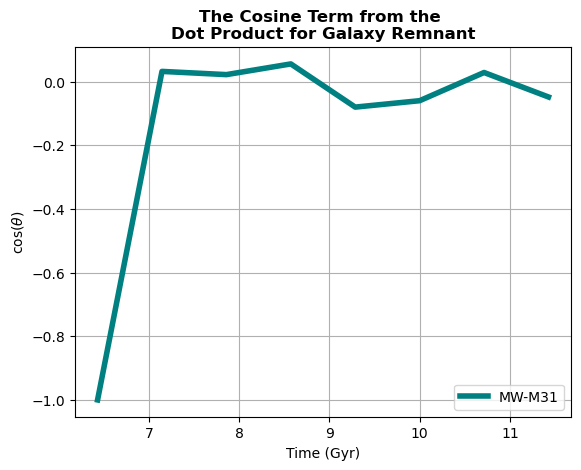

In [22]:
# plot the dot product as a function of time POST-MERGER

plt.title('The Cosine Term from the \nDot Product for Galaxy Remnant').set_weight('bold')

plt.plot(times_post[:-1], remnant_cos, lw=4, color='teal', label='MW-M31')

plt.legend()
plt.grid(True)

# add axis labels
plt.xlabel('Time (Gyr)')
plt.ylabel(r'cos($\theta$)')

# adjust tick label font size
label_size = 10
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('CosineTermVsTimePOSTMERGER.png')

# CONCATENATE RADIUS AND VELOCITY ARRAYS
# COMPUTE COM